# The problem

Let $\Omega =  (-1,1)\times (-1,1)$, the problem is

---

$$
\begin{cases}
u_{xx}+u_{yy} = 0, & \qquad\text{for}\; (x,y)\in (-1,1)\times (-1,1),\\
u(x,y) = xy , &\qquad\text{for}\; (x,y)\in \partial \Omega
\end{cases}
$$ 

---

The exact solution is 

---

$$u(x,y) = xy $$

---

The Loss is

$$ L(\hat{u}) = \frac{1}{N^2}\sum_{j=1}^N\sum_{i=1}^N \Big(u_{xx} + u_{yy}\Big)^2$$

# Loading libraries

In [1]:
# Import libraries
import numpy as np
import math
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [ ]:
import matplotlib.pyplot as plt
def draw_loss(iter, loss, title='Loss'):
    plt.plot(iter, loss, '-b', label='loss')
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)
    # save image
    plt.savefig(title +".png")  # should before show method
    # show
    plt.show()

def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')
    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.axis('off')
    
    # save image
    plt.savefig(title+".png")  # should before show method
    # show
    plt.show()

from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    "Credit: Ben Moseley"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

def graph(x, y, u_hat):
    X = x.detach().numpy()
    Y = y.detach().numpy()
    Z = u_hat.detach().numpy()
    true_sol = X*Y
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    ax.plot_surface(X, Y, Z,  
                    rstride=1, cstride=1,
                    cmap='winter', edgecolor='none')
    ax.title.set_text('neural network')
    ax.set_zlim([-1,1])

    ax = fig.add_subplot(1, 3, 2, projection='3d')  
    ax.plot_surface(X, Y, true_sol,  
                    rstride=1, cstride=1,
                    cmap='autumn', edgecolor='none')     
    ax.title.set_text('true solution')

    # ax = fig.add_subplot(1, 3, 3, projection='3d')  
    # ax.plot_surface(X, Y, Z,  
    #                 rstride=1, cstride=1,
    #                 cmap='winter', edgecolor='none')
    # ax.plot_surface(X, Y, true_sol,  
    #                 rstride=1, cstride=1,
    #                 cmap='autumn', edgecolor='none')    
    # ax.title.set_text('joint plot')           

# Finite difference

In [2]:
N = 32
xs = torch.linspace(-1, 1, steps=N, requires_grad=True)
ys = torch.linspace(-1, 1, steps=N, requires_grad=True)
x, y = torch.meshgrid(xs, ys, indexing='xy')
[step_x, step_y] = [2/(N-1),2/(N-1)]

In [5]:
27/31

0.8709677419354839

In [3]:
xs

tensor([-1.0000, -0.9355, -0.8710, -0.8065, -0.7419, -0.6774, -0.6129, -0.5484,
        -0.4839, -0.4194, -0.3548, -0.2903, -0.2258, -0.1613, -0.0968, -0.0323,
         0.0323,  0.0968,  0.1613,  0.2258,  0.2903,  0.3548,  0.4194,  0.4839,
         0.5484,  0.6129,  0.6774,  0.7419,  0.8065,  0.8710,  0.9355,  1.0000],
       requires_grad=True)

In [ ]:
def gradient(u, step_x, step_y):
    # all inputs are (n*n)-dim pytorch tensor
    [Nx, Ny] = list(u.size())
    u_x_tensor = 0*u.clone()
    for row in range(1, Ny-1):
        u_x_tensor[row, 1:-1] = (-u[row, 0:-2] + u[row, 2:])/(2*step_x)
    u_y_tensor = 0*u.clone()
    for col in range(1, Nx-1):
        u_y_tensor[1:-1, col] = (-u[0:-2, col] + u[2:, col])/(2*step_y)
    return [u_x_tensor, u_y_tensor]    

def abs_grad(u, step_x, step_y):
    [u_x, u_y] = gradient(u, step_x, step_y)
    return torch.sqrt(torch.square(u_x) + torch.square(u_y))

def Laplacian(u, step_x, step_y):
    [Nx, Ny] = list(u.size())
    u_xx = 0*u.clone()
    for row in range(1, Ny-1):
        u_xx[row, 1:-1] = (u[row, 0:-2] + u[row, 2:] - 2*u[row, 1:-1])/(step_x**2)
    u_yy = 0*u.clone()
    for col in range(1, Nx-1):
        u_yy[1:-1, col] = (u[0:-2, col] + u[2:, col] - 2*u[1:-1, col])/(step_y**2)
    return (u_xx + u_yy)

In [ ]:
def PDEsNet(input_size=2, output_size=1, k=32):
    model = nn.Sequential(
        nn.Linear(input_size, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, output_size),
        nn.Tanh(),
        )
    return model
# module5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
# init.xavier_normal_(module5.weight)

In [ ]:
def unpack_column(xs, ys, Nx, Ny):
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    # unpack_col = []
    for i in range(0, Nx):
        row_i = torch.stack([x[:,i],y[:,i]], dim=1)
        if i == 0:
            unpack_col = row_i
        else:    
            unpack_col = torch.vstack([unpack_col,row_i])
    return unpack_col        

def pack_column(u, Nx, Ny):
    return torch.transpose(u.reshape((Nx, Ny)), 0, 1)

# Training

In [ ]:
[Nx, Ny] = [len(x), len(y)]

In [ ]:
torch.manual_seed(111)
model = PDEsNet(input_size=2, output_size=1, k=8)
files = []

In [ ]:
loss_mse = nn.MSELoss()

def Loss(u, xs, ys, eps, step_x, step_y):
    [Nx, Ny] = list(u.size())
    # all inputs are (n*n)-dim pytorch tensor

    zero_tensor = torch.zeros(Nx, Ny, dtype=torch.float32)
    l = Laplacian(u,step_x,step_y)
   
    result = loss_mse(Laplacian(u,step_x,step_y), zero_tensor) 
    return result

The running loss at 099 iteration is: 53.21335220336914
The running loss at 199 iteration is: 40.70503234863281
The running loss at 299 iteration is: 34.87492752075195
The running loss at 399 iteration is: 30.638660430908203
The running loss at 499 iteration is: 26.297971725463867


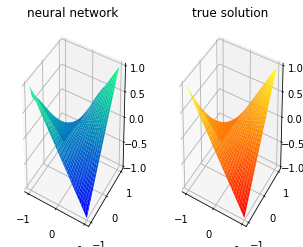

The running loss at 599 iteration is: 19.35445213317871
The running loss at 699 iteration is: 10.791901588439941
The running loss at 799 iteration is: 6.677228927612305
The running loss at 899 iteration is: 4.744842052459717
The running loss at 999 iteration is: 3.778103828430176


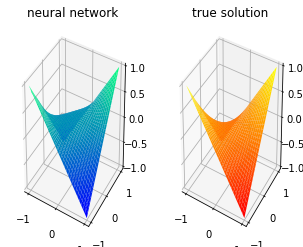

The running loss at 1099 iteration is: 3.2314507961273193
The running loss at 1199 iteration is: 2.882993459701538
The running loss at 1299 iteration is: 2.6427083015441895
The running loss at 1399 iteration is: 2.4931325912475586
The running loss at 1499 iteration is: 2.327332019805908


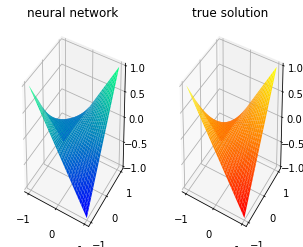

The running loss at 1599 iteration is: 2.5502045154571533
The running loss at 1699 iteration is: 2.1023101806640625
The running loss at 1799 iteration is: 2.002042055130005
The running loss at 1899 iteration is: 2.0306105613708496
The running loss at 1999 iteration is: 1.8052418231964111


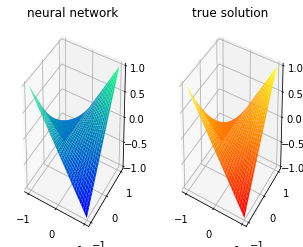

The running loss at 2099 iteration is: 1.7044310569763184
The running loss at 2199 iteration is: 1.7578848600387573
The running loss at 2299 iteration is: 1.480316162109375
The running loss at 2399 iteration is: 1.357932686805725
The running loss at 2499 iteration is: 1.3422908782958984


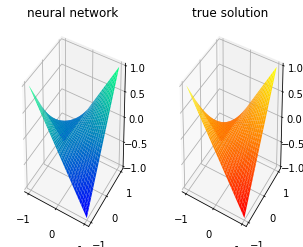

The running loss at 2599 iteration is: 1.0724841356277466
The running loss at 2699 iteration is: 0.9232170581817627
The running loss at 2799 iteration is: 0.7735967040061951
The running loss at 2899 iteration is: 1.3763002157211304
The running loss at 2999 iteration is: 0.5122057795524597


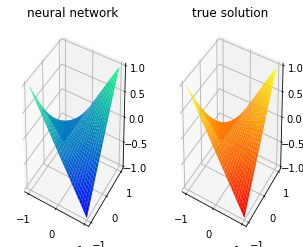

The running loss at 3099 iteration is: 0.42655354738235474
The running loss at 3199 iteration is: 0.38467395305633545
The running loss at 3299 iteration is: 0.33097153902053833
The running loss at 3399 iteration is: 0.3093569576740265
The running loss at 3499 iteration is: 0.7534065842628479


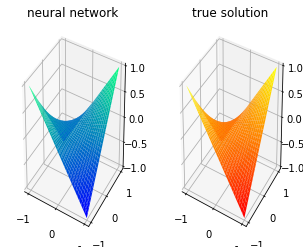

The running loss at 3599 iteration is: 0.28521209955215454
The running loss at 3699 iteration is: 0.2741378843784332
The running loss at 3799 iteration is: 0.2642044126987457
The running loss at 3899 iteration is: 0.2714137136936188
The running loss at 3999 iteration is: 0.2516744136810303


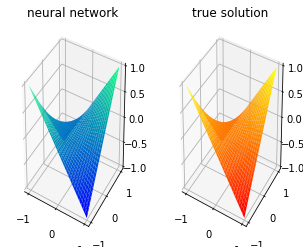

The running loss at 4099 iteration is: 0.24308395385742188
The running loss at 4199 iteration is: 0.963735818862915
The running loss at 4299 iteration is: 0.23195208609104156
The running loss at 4399 iteration is: 0.22418510913848877
The running loss at 4499 iteration is: 0.2945217490196228


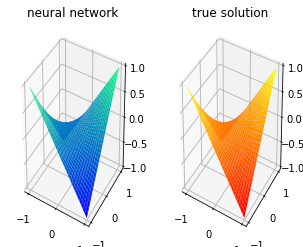

The running loss at 4599 iteration is: 0.2149479240179062
The running loss at 4699 iteration is: 0.20798616111278534
The running loss at 4799 iteration is: 0.2079758644104004
The running loss at 4899 iteration is: 0.19940203428268433
The running loss at 4999 iteration is: 0.19800971448421478


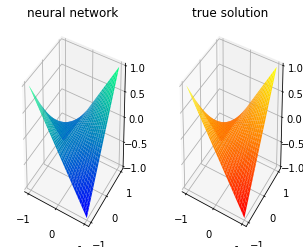

The running loss at 5099 iteration is: 0.19317658245563507
The running loss at 5199 iteration is: 0.18557965755462646
The running loss at 5299 iteration is: 2.146944761276245
The running loss at 5399 iteration is: 0.18021167814731598
The running loss at 5499 iteration is: 0.17371322214603424


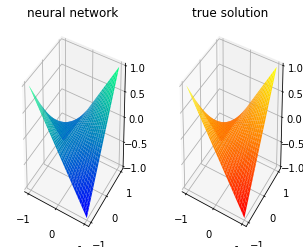

The running loss at 5599 iteration is: 0.16818447411060333
The running loss at 5699 iteration is: 0.170266792178154
The running loss at 5799 iteration is: 0.16187027096748352
The running loss at 5899 iteration is: 0.22484971582889557
The running loss at 5999 iteration is: 0.15705235302448273


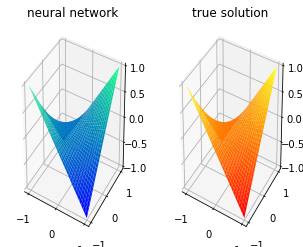

The running loss at 6099 iteration is: 0.1514628529548645
The running loss at 6199 iteration is: 0.14628663659095764
The running loss at 6299 iteration is: 0.1465660184621811
The running loss at 6399 iteration is: 0.14094191789627075
The running loss at 6499 iteration is: 0.1359594762325287


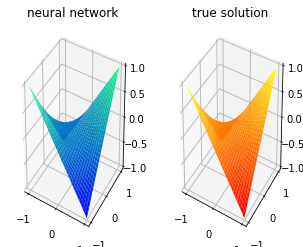

The running loss at 6599 iteration is: 0.1384492665529251
The running loss at 6699 iteration is: 0.13093748688697815
The running loss at 6799 iteration is: 0.1259932816028595
The running loss at 6899 iteration is: 0.12763258814811707
The running loss at 6999 iteration is: 0.12108422070741653


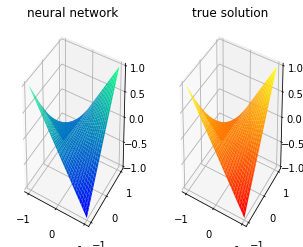

The running loss at 7099 iteration is: 0.11618256568908691
The running loss at 7199 iteration is: 0.13924381136894226
The running loss at 7299 iteration is: 0.11046145111322403
The running loss at 7399 iteration is: 0.10566415637731552
The running loss at 7499 iteration is: 0.10833247750997543


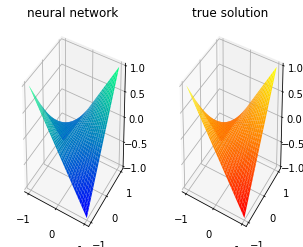

The running loss at 7599 iteration is: 0.10013718903064728
The running loss at 7699 iteration is: 0.09536514431238174
The running loss at 7799 iteration is: 0.11119642853736877
The running loss at 7899 iteration is: 0.09026064723730087
The running loss at 7999 iteration is: 0.08548901230096817


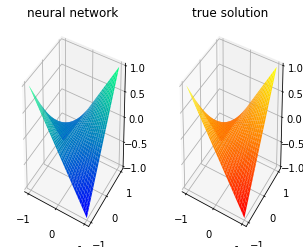

In [ ]:
# torch.autograd.set_detect_anomaly(True)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

eps = 0.01
iter = []
loss_array = []
num_e = 8000
for e in range(num_e):
    running_loss = 0
    optimizer.zero_grad() 

    coordinates = unpack_column(xs, ys, Nx, Ny)
    u_hat_array = model(coordinates).clone()  
    u_hat = pack_column(u_hat_array, Nx, Ny)

    u_star = torch.multiply(x,y)

    loss = torch.mean((u_hat[ 0, :] - u_star[ 0, :])**2)
    loss += torch.mean((u_hat[-1, :] - u_star[-1, :])**2)
    loss += torch.mean((u_hat[ :, 0] - u_star[ :, 0])**2)
    loss += torch.mean((u_hat[ :,-1] - u_star[ :,-1])**2)


    u_hat[ 0, :] = u_star[ 0, :]
    u_hat[-1, :] = u_star[-1, :]
    u_hat[ :, 0] = u_star[ :, 0]
    u_hat[ :,-1] = u_star[ :,-1]

    # [Nx, Ny] = list(u_hat.size())
    # all inputs are (n*n)-dim pytorch tensor

    l = Laplacian(u_hat,step_x,step_y)
  
    loss = loss + torch.mean(Laplacian(u_hat,step_x,step_y)**2) 
    # print(loss)
   
    loss.backward()
    optimizer.step() 

    running_loss += loss.clone().item()   
    loss_array.append(running_loss)
    iter.append(e)

    if ((e+1) % 100 == 0):
        print(f"The running loss at {(e):03d} iteration is: {running_loss}")

        graph(x, y, u_hat)
        file = "nn_%.8e.png"%(e+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecollor='white') 
        files.append(file)

        if (e+1)%500 == 0:
            plt.show()
        else:
            plt.close("all")

In [ ]:
    X = x.detach().numpy()
    Y = y.detach().numpy()
    Z = u_hat.detach().numpy()
    true_sol = X*Y
    np.mean((true_sol-Z)**2)

0.0002670784

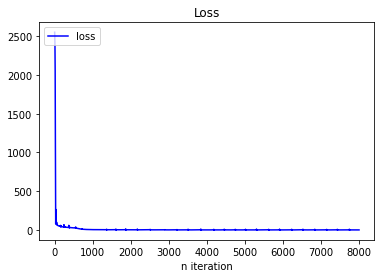

In [ ]:
save_gif_PIL("nn.gif", files, fps=20, loop=0)
draw_loss(iter, loss_array, title='Loss')

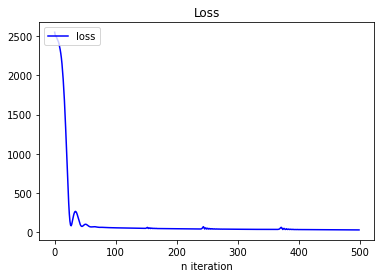

In [ ]:
draw_loss(iter[:500], loss_array[:500], title='Loss')

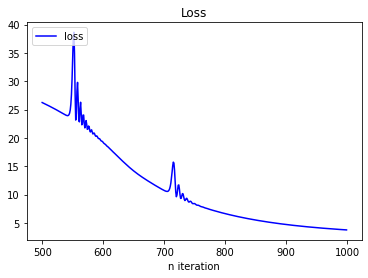

In [ ]:
draw_loss(iter[500:1000], loss_array[500:1000], title='Loss')

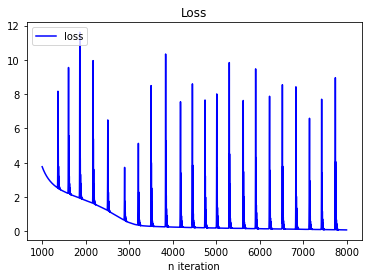

In [ ]:
draw_loss(iter[1000:], loss_array[1000:], title='Loss')

# Plot

In [ ]:
import webbrowser
webbrowser.open('/content/nn.gif')

False

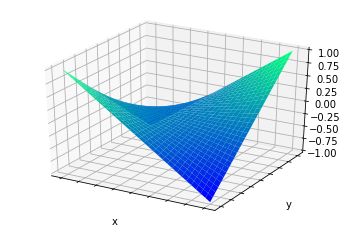

In [ ]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_ylabel('y')
ax.set_xlabel('x')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

X = x.detach().numpy()
Y = y.detach().numpy()
Z = u_hat.detach().numpy()
# ax.plot_surface(x.detach().numpy(), y.detach().numpy(), u_hat.detach().numpy())
ax.plot_surface(X, Y, Z,  
                rstride=1, cstride=1,
                cmap='winter', edgecolor='none')

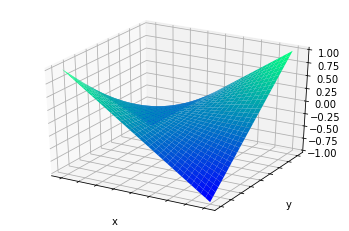

In [ ]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_ylabel('y')
ax.set_xlabel('x')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

X = x.detach().numpy()
Y = y.detach().numpy()
Z = u_star.detach().numpy()
# ax.plot_surface(x.detach().numpy(), y.detach().numpy(), u_hat.detach().numpy())
ax.plot_surface(X, Y, Z,  
                rstride=1, cstride=1,
                cmap='winter', edgecolor='none')

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Surface(z=Z, x=X, y=Y, colorscale="Reds", opacity=0.5)])
fig.update_layout(
    title='My title', 
    autosize=False,
    width=500, 
    height=500,
    margin=dict(l=65, r=50, b=65, t=90), 
    scene_aspectmode='cube'
)
fig.show()